# Exercise 1
Berkay Günes, Buhar Bacho, Sophia Klubertz

## 1 Exploring the Data

In [1]:
from sklearn.datasets import load_digits
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

In [2]:
digits = load_digits()

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

Text(0.5, 1.0, "Interpolation methode 'nearest'")

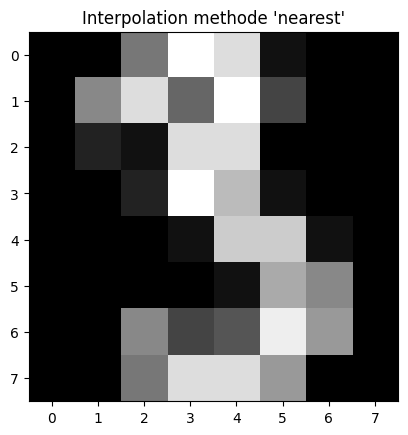

In [3]:
img = images[3]
assert 2 == len(img.shape)
plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest")
plt.title("Interpolation methode 'nearest'")

Text(0.5, 1.0, "Interpolation methode 'bicubic'")

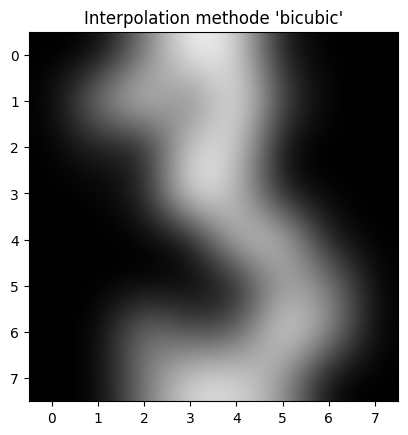

In [4]:
plt.imshow(img, interpolation="bicubic")
plt.title("Interpolation methode 'bicubic'")

In [5]:
mask = np.logical_or(target == 3,target == 9)

X_all = data[mask]
y_all = target[mask]

X_train , X_test , y_train , y_test =\
    model_selection.train_test_split(X_all, y_all, test_size = 0.4, random_state = 0)

## 2 Hand-crafted classifier
### 2.1 Feature construction
To determine the important pixels for a classification we first look at the difference between the average 3's and 9's. 

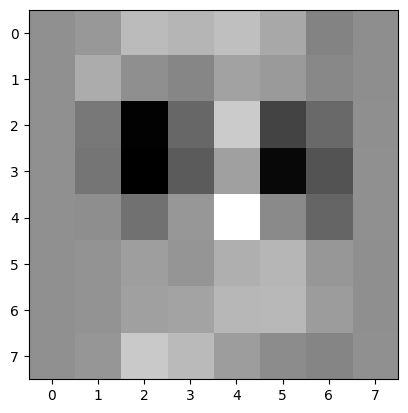

In [6]:
av3 = sum(images[target == 3]) / len(images[target == 3])
av9 = sum(images[target == 9]) / len(images[target == 9])

diff39 = (av3-av9)
plt.imshow(diff39, interpolation='nearest')

This image shows us in which pixels the difference is biggest between the 3's and 9's. <br>
The four pixels to focus on are (2,2), (2,3), (4,4) and (5,3), but not all four pixels are equaly important. 

In [7]:
def features2d(x):
    pc = np.zeros((len(x), 2))
    
    for i in range(0, len(x)):
        pc[i, 0] = 8.8 * x[i, 8*2+2] + 9 * x[i, 8*3+2] + 8.5 * x[i, 8*3+5] + 4.8 * x[i, 8*2+5]
        pc[i, 1] = 7 * x[i, 8*4+4] + 3.7 * x[i, 8*2+4] + 3.6 * x[i, 8*7+2]
        
    return pc

In [8]:
features = features2d(X_all)

### 2.2 Scatterplot

Text(0, 0.5, 'PC2')

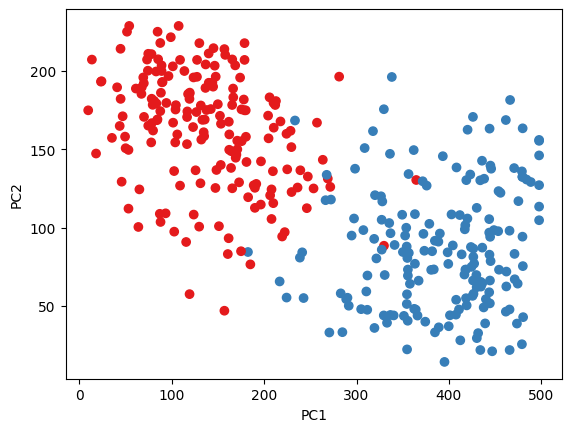

In [9]:
colors = ['#e41a1c', '#377eb8']
labels = np.empty(len(y_all), dtype = int)
labels[y_all == 9] = 1
labels[y_all == 3] = 0

plt.scatter(features.T[0], features.T[1], color=np.array(colors)[labels])
plt.xlabel("PC1")
plt.ylabel("PC2")

### 2.3 Decision rule

In [10]:
training_features = features2d(X_train)
test_features = features2d(X_test)
training_labels = y_train

In [11]:
def nearest_mean(training_features, training_labels, test_features):
    
    mean_3 = sum(training_features[training_labels == 3]) / len(training_features[training_labels == 3])
    mean_9 = sum(training_features[training_labels == 9]) / len(training_features[training_labels == 9])
    
    dis_3 = np.linalg.norm(mean_3 - test_features, axis = 1)
    dis_9 = np.linalg.norm(mean_9 - test_features, axis = 1)
    
    d = dis_3 - dis_9
    
    label = np.empty(len(d), dtype = int)
    
    label[d < 0] = 3
    label[d > 0] = 9
    
    return label, mean_3, mean_9

In [12]:
predicted_labels, mean_3, mean_9 = nearest_mean(training_features, y_train, test_features)

In [13]:
error = abs(100*(sum(y_test == predicted_labels)-len(y_test))/len(y_test))
print("The classifier misclassified %f %% of the data" % round(error,2))

The classifier misclassified 2.740000 % of the data


### 2.4 Visualize the decision regions

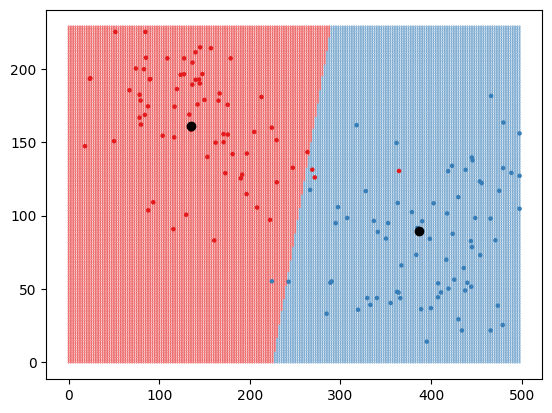

In [14]:
fig, ax = plt.subplots()

y = np.linspace(0,max(features.T[1]),200)
for i in range(0, len(y)):
    grid = np.array([np.linspace(0,max(features.T[0]),200), np.ones(200)*y[i]])
    grid_labels, mean_3, mean_9 = nearest_mean(training_features, training_labels, grid.T)
    grid_labels[grid_labels == 9] = 1
    grid_labels[grid_labels == 3] = 0
    ax.scatter(grid[0], grid[1], color = np.array(colors)[grid_labels], s = 0.1)

predicted_labels_c = y_test
predicted_labels_c[predicted_labels_c == 9] = 1
predicted_labels_c[predicted_labels_c == 3] = 0
    
ax.scatter(test_features.T[0], test_features.T[1], color=np.array(colors)[y_test], s = 5)
ax.scatter(mean_3[0], mean_3[1], c = 'black')
ax.scatter(mean_9[0], mean_9[1], c = 'black')

## 3 LDA
### 3.1 Implement LDA training

In [15]:
def fit_lda(tf, tl):
    D = np.shape(tf)[1]
    mu = np.zeros((2,D))
    
    for i in range(0,D):
        mu[0, i] = np.mean(tf[tl==3].T[i])
        mu[1, i] = np.mean(tf[tl==9].T[i])
    
    covmat = 1/len(tf) * (len(tf[tl==3]) * np.cov(tf[tl==3].T) + len(tf[tl==9]) * np.cov(tf[tl==9].T))
    
    p = np.zeros((2,1))
    p[0] = len(tf[tl==3])/len(tf)
    p[1] = len(tf[tl==9])/len(tf)
    
    return mu, covmat, p
    
mu, covmat, p = fit_lda(training_features, training_labels)

### 3.2 Implement LDA prediction

In [16]:
def predict_lda(mu, covmat, p, testf):
    
    beta = np.linalg.inv(covmat) @ ( mu[0].T - mu[1].T )
    b = 0.5 * (mu[1] @ np.linalg.inv(covmat) @ mu[1].T - mu[0] @ np.linalg.inv(covmat) @ mu[0].T)
    
    y = np.sign(testf @ beta + b)
    
    y[y==-1] = 3
    y[y== 1] = 9
    
    print(b)
    print(beta)
    
    return y.astype(int)

predicted_labels = predict_lda(mu, covmat, p, test_features)

10.09365712432796
[-0.05488231  0.03358322]


### 3.3 Visualization
Plotting of the training features and the gaussian.

In [ ]:
fig, ax = plt.subplots()

y = np.linspace(0,max(features.T[1])+30,250)
for i in range(0, len(y)):
    grid = np.array([np.linspace(0,max(features.T[0])+30,250), np.ones(250)*y[i]])
    grid_labels = predict_lda(mu, covmat, p, grid.T)
    grid_labels[grid_labels == 9] = 0
    grid_labels[grid_labels == 3] = 1
    ax.scatter(grid[0], grid[1], color = np.array(colors)[grid_labels], s = 0.1)
    
predicted_labels_c = y_train
predicted_labels_c[predicted_labels_c == 9] = 1
predicted_labels_c[predicted_labels_c == 3] = 0

x,y = np.mgrid[0:530:1,0:250:1]
data = np.dstack((x,y))
z_1 = multivariate_normal(mu[0], covmat).pdf(data)
ax.contour(x,y,z_1,linewidths=0.5)
z_2 = multivariate_normal(mu[1], covmat).pdf(data)
ax.contour(x,y,z_2,linewidths=0.5)
    
#ax.scatter(test_features.T[0], test_features.T[1], color=np.array(colors)[y_test], s = 10)
ax.scatter(training_features.T[0], training_features.T[1], color=np.array(colors)[predicted_labels_c], s = 10)
ax.scatter(mu[0,0], mu[0,1], c = 'black')
ax.scatter(mu[1,0], mu[1,1], c = 'black')

eig_val, eig_vec = np.linalg.eig(covmat)

ax.arrow(mu[1,0], mu[1,1], np.sqrt(eig_val[0])*eig_vec[:,0][0], np.sqrt(eig_val[0])*eig_vec[:,0][1], width = 2)
ax.arrow(mu[1,0], mu[1,1], np.sqrt(eig_val[1])*eig_vec[:,1][0], np.sqrt(eig_val[0])*eig_vec[:,1][1], width = 2)

ax.arrow(mu[0,0], mu[0,1], np.sqrt(eig_val[0])*eig_vec[:,0][0], np.sqrt(eig_val[0])*eig_vec[:,0][1], width = 2)
ax.arrow(mu[0,0], mu[0,1], np.sqrt(eig_val[1])*eig_vec[:,1][0], np.sqrt(eig_val[0])*eig_vec[:,1][1], width = 2)
plt.title("Training data")

In [ ]:
fig, ax = plt.subplots()

y = np.linspace(0,max(features.T[1])+30,250)
for i in range(0, len(y)):
    grid = np.array([np.linspace(0,max(features.T[0])+30,250), np.ones(250)*y[i]])
    grid_labels = predict_lda(mu, covmat, p, grid.T)
    grid_labels[grid_labels == 9] = 0
    grid_labels[grid_labels == 3] = 1
    ax.scatter(grid[0], grid[1], color = np.array(colors)[grid_labels], s = 0.1)
    
predicted_labels_c = y_train
predicted_labels_c[predicted_labels_c == 9] = 1
predicted_labels_c[predicted_labels_c == 3] = 0

x,y = np.mgrid[0:530:1,0:250:1]
data = np.dstack((x,y))
z_1 = multivariate_normal(mu[0], covmat).pdf(data)
ax.contour(x,y,z_1,linewidths=0.5)
z_2 = multivariate_normal(mu[1], covmat).pdf(data)
ax.contour(x,y,z_2,linewidths=0.5)
    
ax.scatter(test_features.T[0], test_features.T[1], color=np.array(colors)[y_test], s = 10)
#ax.scatter(training_features.T[0], training_features.T[1], color=np.array(colors)[predicted_labels_c], s = 5, marker = "x")
ax.scatter(mu[0,0], mu[0,1], c = 'black')
ax.scatter(mu[1,0], mu[1,1], c = 'black')

eig_val, eig_vec = np.linalg.eig(covmat)

ax.arrow(mu[1,0], mu[1,1], np.sqrt(eig_val[0])*eig_vec[:,0][0], np.sqrt(eig_val[0])*eig_vec[:,0][1], width = 2)
ax.arrow(mu[1,0], mu[1,1], np.sqrt(eig_val[1])*eig_vec[:,1][0], np.sqrt(eig_val[0])*eig_vec[:,1][1], width = 2)

ax.arrow(mu[0,0], mu[0,1], np.sqrt(eig_val[0])*eig_vec[:,0][0], np.sqrt(eig_val[0])*eig_vec[:,0][1], width = 2)
ax.arrow(mu[0,0], mu[0,1], np.sqrt(eig_val[1])*eig_vec[:,1][0], np.sqrt(eig_val[0])*eig_vec[:,1][1], width = 2)

plt.title("Testing data")

### 3.4 Quantitative performance evaluation

In [ ]:
def lda_cv(x,y):
    kf = KFold(n_splits = 10, shuffle = True)
    error = []
    
    for train_lda, test_lda in kf.split(x):
        x_train, y_train = x[train_lda], y[train_lda]
        x_test, y_test   = x[test_lda] , y[test_lda]
        mu, covmat, p = fit_lda(features2d(x_train), y_train)
        labels = predict_lda(mu, covmat, p, features2d(x_test))
        fp = 0
        fn = 0
        for i in range(len(y_test)):
            if (labels[i] == 3) and (y_test[i] != 3):
                fp = fp + 1
            if (labels[i] != 3) and (y_test[i] == 3):
                fn = fn + 1
            if (labels[i] == 9) and (y_test[i] != 9):
                fp = fp + 1
            if (labels[i] != 9) and (y_test[i] == 9):
                fn = fn + 1
        error.append((fp+fn)/len(labels))
    
    return error

error = lda_cv(X_all, y_all)

In [ ]:
clf = LinearDiscriminantAnalysis()
scores = cross_val_score(clf, X_all, y_all, cv = 10)

In [ ]:
fig, ax = plt.subplots()

ax.plot(np.linspace(1,10,10), error, label = "own LDA implementation")
ax.plot(np.linspace(1,10,10), scores, label = "sklearn's LDA implementation")
ax.legend()

Our own classifier seems to work quite consistantly with just a small variation. The build in classifier from sklearn is still quite a lot more accurate in predicting the labels though.

## 4 SVM

In [93]:
#due to the minimization of the loss-function the SVM-alogorithm will find opatimal parameters for the seperation of the classes
class SVM:
    
    #define instances
    #learning_rate (Tau) determines the stepsize of the system, C balances the maximization of the margin and right classification
    #max_iter is the number of iteration, system should convergete but not be to slow
    
    def __init__(self, Tau=0.01, lambd=0.1, max_iter=1000):
        self.Tau= Tau
        self.lambd=lambd
        self.max_iter=max_iter
        self.beta= None #initialize w and b
        self.b= None
        
    #find optimal parameters beta and b 
    #calculate fit-parameters, i.e. mean and covariance-matrix
    def fit(self, X, y):        
        self.beta= np.random.normal(0,1,len(X.T)) #length = number of features (not reduced)
        self.b= 0
        
        y[y == 3] = -1 #rename
        y[y == 9] = 1
        
        i=0
        while i < self.max_iter:
            #initialize predicted labels
            y_pred = np.dot(X , self.beta) + self.b

            #Formula of the gradients (see sheet)
            gradient_beta = self.beta + self.lambd/len(X) * np.dot(np.where(y*y_pred < 1, -y, 0), X) #len(X)=number of the samples
            gradient_b = self.lambd/len(X) * np.sum(np.where(y*y_pred < 1, -y, 0))

            #optimize these parameters (see sheet)
            self.beta = self.beta - self.Tau * gradient_beta
            self.b = self.b - self.Tau * gradient_b
            i +=1
            
    #predicted labels
    def predict(self, X):
        y_pred=np.sign(np.dot(X , self.beta) + self.b)
        y_pred[y_pred==-1] = 3 #rename
        y_pred[y_pred== 1] = 9
        return y_pred.astype(int)

In [94]:
svm=SVM()
svm.fit(training_features, training_labels)
y_pred = svm.predict(test_features)
print(y_pred)

[9 9 9 3 3 9 9 9 9 9 3 3 9 3 9 3 3 9 9 9 3 9 3 3 3 3 3 9 9 3 9 9 9 3 9 9 9
 9 3 3 3 9 3 3 3 3 3 3 3 3 3 9 9 9 9 9 9 3 3 9 9 3 3 3 9 9 3 9 3 9 3 3 3 3
 9 3 3 3 9 3 3 9 9 9 9 3 9 3 9 3 9 3 9 3 9 9 9 9 3 9 3 3 3 3 9 9 3 3 9 9 3
 9 9 9 3 3 3 9 9 9 9 9 3 3 9 3 3 9 3 9 9 9 9 9 9 9 9 9 3 3 9 3 3 3 9 9]


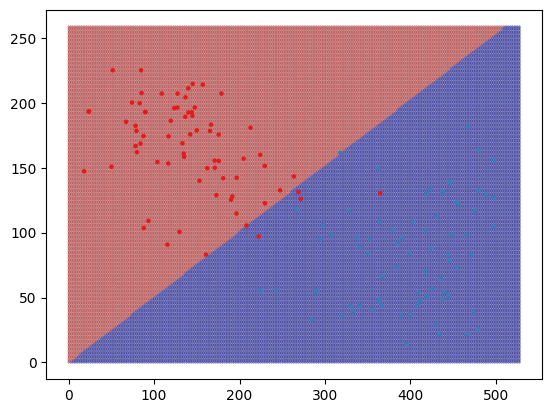

In [103]:
fig, ax = plt.subplots()

y = np.linspace(0,max(features.T[1])+30,250)
for i in range(0, len(y)):
    grid = np.array([np.linspace(0,max(features.T[0])+30,250), np.ones(250)*y[i]])
    grid_labels = svm.predict(grid.T).astype('str')
    grid_labels[grid_labels == "9"] = "#1a1c8a" 
    grid_labels[grid_labels == "3"] = "#a83232"
    ax.scatter(grid[0], grid[1], c = grid_labels, s = 0.1)
    
predicted_labels_c = y_test
predicted_labels_c[predicted_labels_c == 9] = 1
predicted_labels_c[predicted_labels_c == 3] = 0
    
ax.scatter(test_features.T[0], test_features.T[1], color=np.array(colors)[y_test], s = 5)